In [16]:
!pip install matplotlib seaborn shap lightgbm


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, precision_score, recall_score, precision_recall_curve
from sklearn.preprocessing import LabelEncoder


In [21]:


# 1. Load CSV efficiently

def reduce_mem_usage(df):
    """ Downcast numeric columns to reduce memory """
    for col in df.select_dtypes(include=["int", "float"]).columns:
        df[col] = pd.to_numeric(df[col], downcast="integer" if "int" in str(df[col].dtype) else "float")
    return df

df = pd.read_csv(r'C:\Users\Ayush\Downloads\Fraud.csv', low_memory=False)
df = reduce_mem_usage(df)

print(f"Shape: {df.shape}")
print(df.head())

Shape: (6362620, 11)
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [23]:
print(df['isFraud'].value_counts(normalize=True))


isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64



Missing values per column:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Class balance:
 isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64


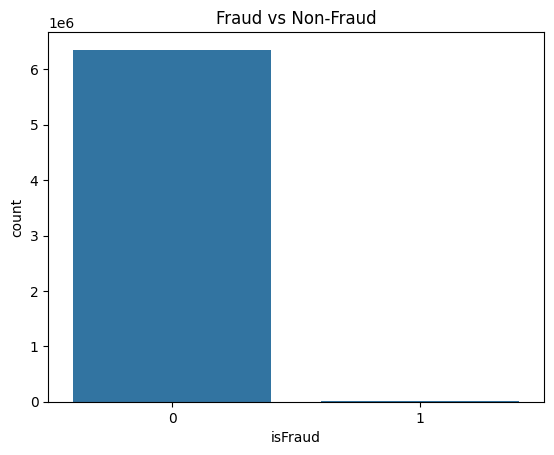

In [26]:

# 2. Basic EDA
print("\nMissing values per column:\n", df.isna().sum())

print("\nClass balance:\n", df['isFraud'].value_counts(normalize=True))

sns.countplot(data=df, x='isFraud')
plt.title("Fraud vs Non-Fraud")
plt.show()



In [27]:


# 3. Feature Engineering
if 'txn_time' in df.columns:
    df['txn_time'] = pd.to_datetime(df['txn_time'], errors='coerce')
    df['hour'] = df['txn_time'].dt.hour
    df['dayofweek'] = df['txn_time'].dt.dayofweek

if 'amount' in df.columns:
    df['log_amount'] = np.log1p(df['amount'])

# Encode categoricals
cat_cols = df.select_dtypes(include="object").columns
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))


In [30]:


# 4. Train/Validation Split
X = df.drop(columns=['isFraud'])
y = df['isFraud']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [31]:


# 5. Baseline Logistic Regression
logreg = LogisticRegression(max_iter=1000, class_weight="balanced")
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict_proba(X_val)[:, 1]

print("\nLogistic Regression ROC-AUC:", roc_auc_score(y_val, y_pred_lr))
print("Logistic Regression PR-AUC:", average_precision_score(y_val, y_pred_lr))




Logistic Regression ROC-AUC: 0.986448045501437
Logistic Regression PR-AUC: 0.5621783537425373


In [33]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, average_precision_score

train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

params = {
    "objective": "binary",
    "metric": "auc",
    "is_unbalance": True,
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "max_depth": -1,
    "verbose": -1
}

lgb_model = lgb.train(
    params,
    train_data,
    valid_sets=[val_data],
    num_boost_round=500,
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

y_pred_lgb = lgb_model.predict(X_val)

print("\nLightGBM ROC-AUC:", roc_auc_score(y_val, y_pred_lgb))
print("LightGBM PR-AUC:", average_precision_score(y_val, y_pred_lgb))


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.99484

LightGBM ROC-AUC: 0.9948404655581985
LightGBM PR-AUC: 0.15721263773963137


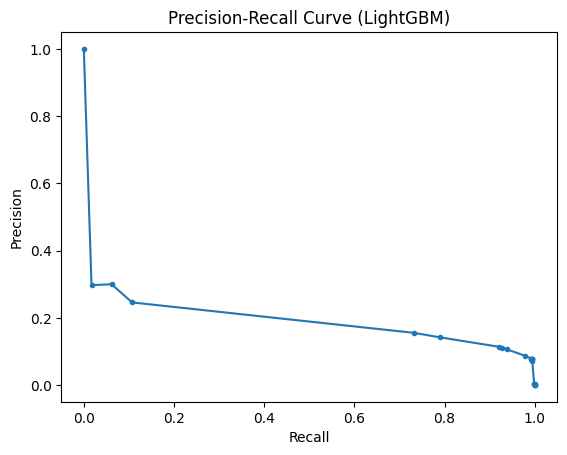

In [34]:


# 7. Precision-Recall Curve

precision, recall, thresholds = precision_recall_curve(y_val, y_pred_lgb)
plt.plot(recall, precision, marker='.')
plt.title("Precision-Recall Curve (LightGBM)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


C:\Users\Ayush\AppData\Local\Programs\Python\Python39\lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


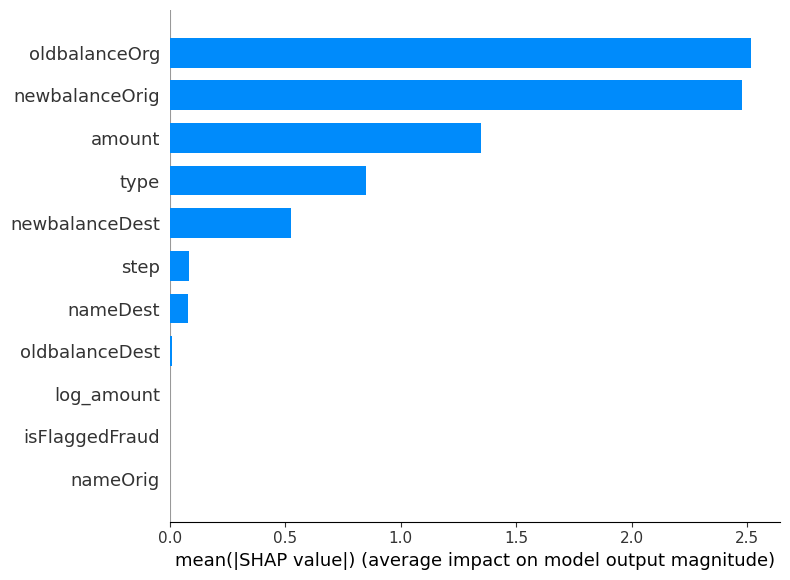

In [35]:


# 8. Feature Importance (SHAP)

explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_val.sample(5000))  

shap.summary_plot(shap_values, X_val.sample(5000), plot_type="bar")